# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

pd.set_option('display.max_columns', None)

# Gender experiment

In [4]:
df_g = pd.read_csv("/Users/mireiafrt/Desktop/MASTER/master-thesis/logs/gender_experiment_results.csv")
df_g.head()

,seed,model,train_loss,val_f1,val_acc,val_auc,val_recall,val_precision,test_f1,test_acc,test_auc,test_recall,test_precision
0,0,A,4.039797,0.800000,0.833333,0.833333,0.666667,1.00,0.692308,0.733333,0.733333,0.600000,0.818182
1,0,B,3.085641,0.750000,0.666667,0.666667,1.000000,0.60,0.578947,0.466667,0.466667,0.733333,0.478261
2,1,A,4.576995,0.857143,0.833333,0.833333,1.000000,0.75,0.636364,0.733333,0.733333,0.466667,1.000000
3,1,B,4.749588,1.000000,1.000000,1.000000,1.000000,1.00,0.125000,0.533333,0.533333,0.066667,1.000000
4,2,A,4.932238,0.666667,0.500000,0.500000,1.000000,0.50,0.380952,0.566667,0.566667,0.266667,0.666667


In [22]:
def plot_results(df, title, custom_labels):
    # Melt validation metrics
    val_metrics = ["val_f1", "val_acc", "val_auc", "val_recall", "val_precision"]
    melted_val = df.melt(id_vars="model", value_vars=val_metrics, var_name="metric", value_name="value")

    # Melt test metrics
    test_metrics = ["test_f1", "test_acc", "test_auc", "test_recall","test_precision"]
    melted_test = df.melt(id_vars="model", value_vars=test_metrics, var_name="metric", value_name="value")

    # Create side-by-side boxplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

    # Validation plot
    sns.boxplot(data=melted_val, x="metric", y="value", hue="model", ax=axes[0])
    axes[0].set_title("Validation Data Performance Metrics")
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, custom_labels, title="Model", loc="lower left")

    # Test plot
    sns.boxplot(data=melted_test, x="metric", y="value", hue="model", ax=axes[1])
    axes[1].set_title("Test Data Performance Metrics")
    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles, custom_labels, title="Model", loc="lower left")

    # Adjust layout
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

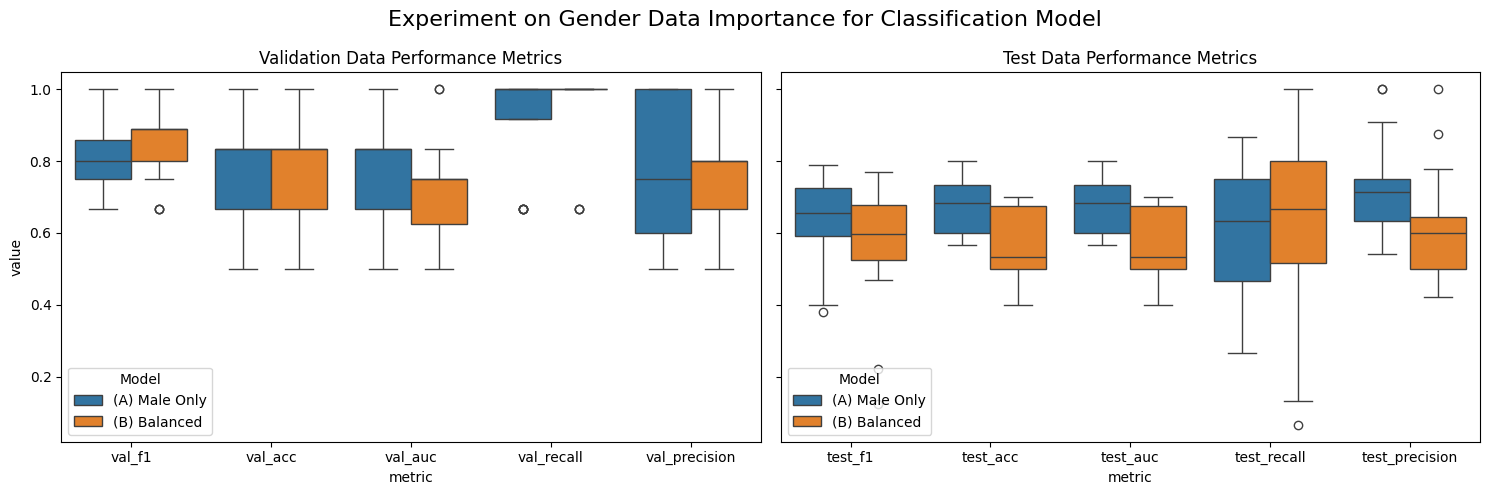

In [ ]:
plot_results(df_g,
             title="Experiment on Gender Data Importance for Classification Model",
             custom_labels=["(A) Male Only", "(B) Balanced"])


# Age experiments

## 40-60 age group

In [17]:
df_a_40_60 = pd.read_csv("/Users/mireiafrt/Desktop/MASTER/master-thesis/logs/age_experiment_results_40_60.csv")
df_a_40_60.head()

,seed,model,train_loss,val_f1,val_acc,val_auc,val_recall,val_precision,test_f1,test_acc,test_auc,test_recall,test_precision
0,0,A,0.363617,0.50,0.6,0.583333,0.5,0.500000,0.000000,0.30,0.230769,0.000000,0.000000
1,0,B,2.127780,0.80,0.8,0.833333,1.0,0.666667,0.521739,0.45,0.543956,0.857143,0.375000
2,1,A,2.592023,1.00,1.0,1.000000,1.0,1.000000,0.000000,0.60,0.500000,0.000000,0.000000
3,1,B,1.881108,0.75,0.6,0.500000,1.0,0.600000,0.600000,0.60,0.625000,0.750000,0.500000
4,2,A,1.698861,0.80,0.8,0.833333,1.0,0.666667,0.560000,0.45,0.576923,1.000000,0.388889


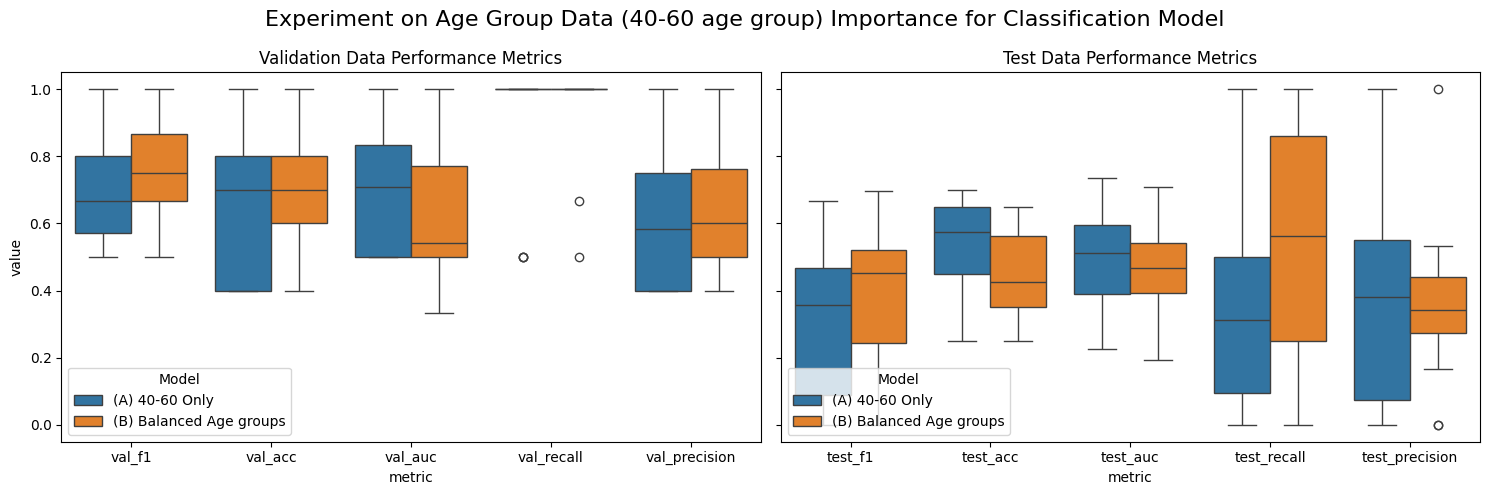

In [25]:
plot_results(df_a_40_60,
             title="Experiment on Age Group Data (40-60 age group) Importance for Classification Model",
             custom_labels=["(A) 40-60 Only", "(B) Balanced Age groups"])

## 60-80 age group

In [26]:
df_a_60_80 = pd.read_csv("/Users/mireiafrt/Desktop/MASTER/master-thesis/logs/age_experiment_results_60_80.csv")
df_a_60_80.head()

,seed,model,train_loss,val_f1,val_acc,val_auc,val_recall,val_precision,test_f1,test_acc,test_auc,test_recall,test_precision
0,0,A,2.548201,0.857143,0.8,0.750000,1.0,0.750000,0.774194,0.65,0.562500,1.000000,0.631579
1,0,B,1.722195,0.400000,0.4,0.416667,0.5,0.333333,0.526316,0.55,0.583333,0.416667,0.714286
2,1,A,1.104655,0.857143,0.8,0.750000,1.0,0.750000,0.750000,0.60,0.500000,1.000000,0.600000
3,1,B,2.456123,0.571429,0.4,0.500000,1.0,0.400000,0.733333,0.60,0.520833,0.916667,0.611111
4,2,A,1.171136,1.000000,1.0,1.000000,1.0,1.000000,0.640000,0.55,0.520833,0.666667,0.615385


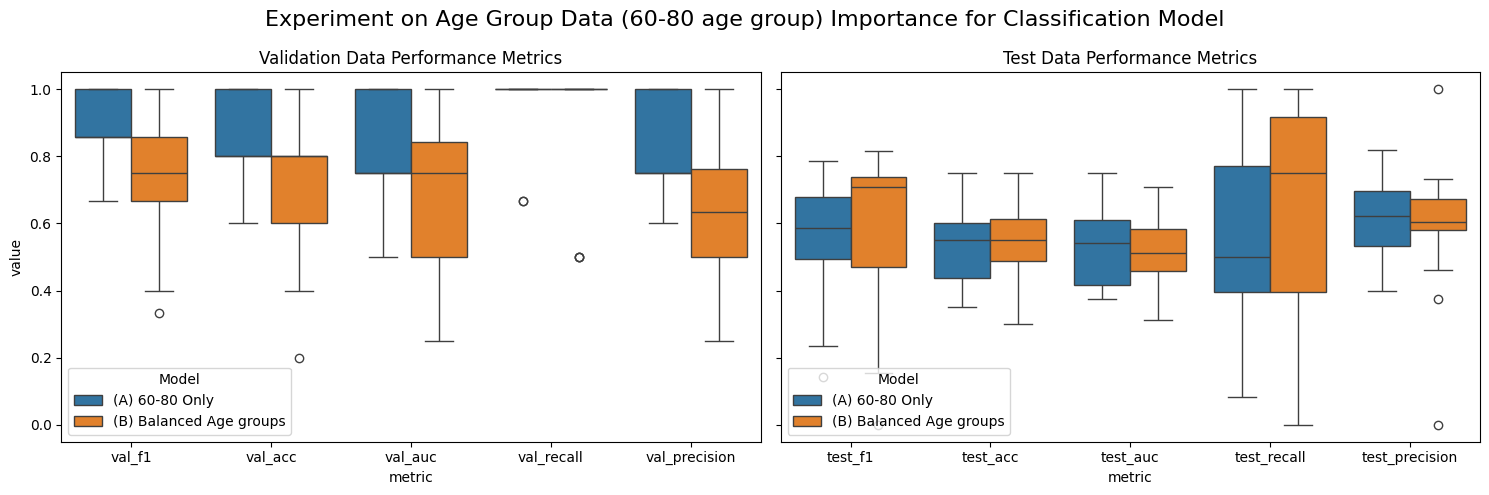

In [27]:
plot_results(df_a_60_80,
             title="Experiment on Age Group Data (60-80 age group) Importance for Classification Model",
             custom_labels=["(A) 60-80 Only", "(B) Balanced Age groups"])